# Fine-tuning



In [1]:
!pip install datasets peft transformers evaluate torch accelerate gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB

### dataset

In [2]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import re as re
import pandas as pd
import gdown
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download the file from GitHub used to test the model performance
!wget -O Model_Test_csv.csv "https://github.com/ilanmoshe52/NLP/blob/d5542fa564a55b4d2fa0e5692ddd49afa8e20d0d/Model_Test_csv.csv"

# Download the file from google drive used to train the model performance
gdown.download(f'https://drive.google.com/file/d/1Gg6rpq-cOADYGtokMkuaEJV0QS7kkHK1/view?usp=drive_link', 'IMDB_Dataset_update.csv', quiet=False , fuzzy = True)

--2024-07-22 18:21:03--  https://github.com/ilanmoshe52/NLP/blob/d5542fa564a55b4d2fa0e5692ddd49afa8e20d0d/Model_Test_csv.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Model_Test_csv.csv’

Model_Test_csv.csv      [ <=>                ] 777.22K  --.-KB/s    in 0.03s   

2024-07-22 18:21:04 (25.0 MB/s) - ‘Model_Test_csv.csv’ saved [795875]



Downloading...
From: https://drive.google.com/uc?id=1Gg6rpq-cOADYGtokMkuaEJV0QS7kkHK1
To: /content/IMDB_Dataset_update.csv
100%|██████████| 66.3M/66.3M [00:01<00:00, 57.9MB/s]


'IMDB_Dataset_update.csv'

In [6]:
df = pd.read_csv('/content/IMDB_Dataset_update.csv')
df.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
# Function to apply the mapping to the dataset
def encode_label(example):
    example['label'] = label_mapping[example['label']]
    return example

# Function to remove special tags from the dataset
def remove_tags(string):
    result = re.sub('[<./br*?>]','',string)
    return result

In [12]:
df['text']=df['text'].apply(lambda cw : remove_tags(cw))
df.head()

,text,label
0,One of the othe eviewes has mentioned that aft...,positive
1,A wondeful little poduction The filming tech...,positive
2,I thought this was a wondeful way to spend tim...,positive
3,Basically thee's a family whee a little oy (Ja...,negative
4,"Pette Mattei's ""Love in the Time of Money"" is ...",positive


In [13]:
from datasets import load_dataset, DatasetDict , Dataset

# Load the dataset
#dataset_idmb = load_dataset('csv', data_files='/content/IMDB Dataset_update.csv')
dataset_idmb = Dataset.from_pandas(df)
# Define the mapping from string labels to integers
label_mapping = {'positive': 1, 'negative': 0}

# Apply the mapping to the dataset
encoded_dataset = dataset_idmb.map(encode_label)

# Split the dataset into training (50%) and validation (50%)
split_dataset = encoded_dataset.train_test_split(test_size=0.5)

# Combine the splits into a DatasetDict
final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': split_dataset['test']
})

# Verify the splits and the label encoding
dataset = final_dataset
print(dataset)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})


In [14]:
# display % of training data with label=1
np.array(dataset['train']['label']).sum()/len(dataset['train']['label'])

0.49808

### model

In [15]:
model_checkpoint = 'distilbert-base-uncased'
# model_checkpoint = 'roberta-base' # you can alternatively use roberta-base but this model is bigger thus training will take longer

# define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# display architecture
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### preprocess data

In [17]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [19]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [20]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### evaluation

In [21]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [22]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

### Apply untrained model to text

In [23]:
# define list of examples
text_list = ["It was good.", "Not a fan, don't recommed.", "Better than the first one.", "This is not worth watching even once.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
It was good. - Positive
Not a fan, don't recommed. - Positive
Better than the first one. - Positive
This is not worth watching even once. - Positive
This one is a pass. - Positive


### Train model

In [24]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [25]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [26]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9307


In [27]:
# hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 5 #10

In [28]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [2]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

NameError: name 'Trainer' is not defined

### Generate prediction

In [1]:
model.to('cpu') # moving to mps for Mac (can alternatively do 'cpu')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cpu") # moving to mps for Mac (can alternatively do 'cpu')

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

NameError: name 'model' is not defined

In [ ]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

('fine_tuned_model/tokenizer_config.json',
 'fine_tuned_model/special_tokens_map.json',
 'fine_tuned_model/vocab.txt',
 'fine_tuned_model/added_tokens.json',
 'fine_tuned_model/tokenizer.json')

In [ ]:
# Save id2label and label2id
import json
with open('/content/fine_tuned_model/id2label.json', 'w') as f:
    json.dump(id2label, f)
with open('/content/fine_tuned_model/label2id.json', 'w') as f:
    json.dump(label2id, f)

In [ ]:
import shutil
from google.colab import files

# Path to the directory containing your model
model_dir = '/content/fine_tuned_model'

# Zip the directory
shutil.make_archive(model_dir, 'zip', model_dir)

# Download the zipped file
files.download(f'{model_dir}.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Optional: load peft model

# Check the performace of the model

In [ ]:
import pandas as pd

encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

# Load the CSV file
for encoding in encodings:
    try:
        df = pd.read_csv('/content/Model_Test_csv.csv', encoding=encoding ,  on_bad_lines='warn')
        print(f"Successfully read the file with {encoding} encoding.")
        break
    except UnicodeDecodeError as e:
        print(f"Failed to read with {encoding} encoding. Error: {e}")

# Display the first few rows of the DataFrame
df.head()

Failed to read with utf-8 encoding. Error: 'utf-8' codec can't decode byte 0xe5 in position 566: invalid continuation byte
Successfully read the file with latin1 encoding.


,text,label
0,I always wrote this series off as being a comp...,negative
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,negative
2,This movie was so poorly written and directed ...,negative
3,The most interesting thing about Miryang (Secr...,positive
4,"when i first read about ""berlin am meer"" i did...",negative


In [ ]:
df['text']=df['text'].apply(lambda cw : remove_tags(cw))
df.head()

,text,label
0,I always wrote this series off as being a comp...,negative
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,negative
2,This movie was so poorly written and directed ...,negative
3,The most interesting thing about Miryang (Secr...,positive
4,"when i first read about ""berlin am meer"" i did...",negative


In [ ]:
verify_text = df['text'].tolist()
verify_score = df['label'].tolist()

In [ ]:
len(verify_text)

499

In [ ]:
sentiment_mapping = {'positive': 1, 'negative': 0}

# Convert the list using list comprehension and the mapping dictionary
verify_score = [sentiment_mapping[sentiment] for sentiment in verify_score]


In [ ]:
texts = verify_text
predictions = []
#print(texts)
# Tokenize the input texts
for text in texts:

  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

  # Run the model
  with torch.no_grad():
      outputs = model(**inputs)

  # Get the logits and convert to probabilities (optional)
  logits = outputs.logits
  probs = torch.nn.functional.softmax(logits, dim=-1)
  predictions.append(torch.argmax(logits, dim=-1).item())

# Get the predicted class indices
# predictions = torch.argmax(logits, dim=-1)
print(predictions)


I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily But then one day a tragic happenstance occurred After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel But then why not just get up and walk across the country to watch TV in another state "Nuts to that", I said So I decided to just hang tight on the couch and take whatever Fate had in store for me What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hairy lighthouse fogh

[[224  42]
 [ 28 205]]
0.8597194388777555
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       266
           1       0.83      0.88      0.85       233

    accuracy                           0.86       499
   macro avg       0.86      0.86      0.86       499
weighted avg       0.86      0.86      0.86       499



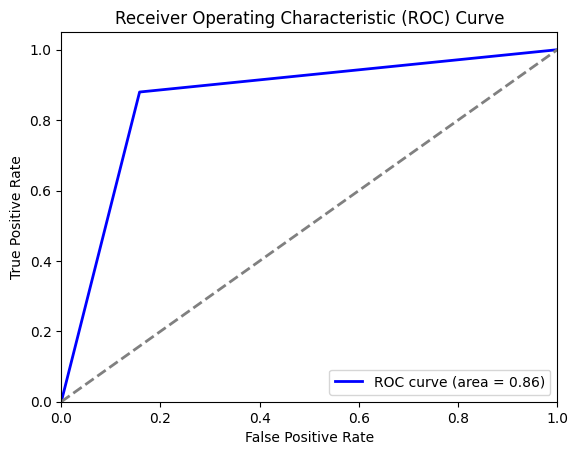

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score , roc_curve , roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

y_pred = predictions
y_true = verify_score

# display confution matrix
cfg_dist = confusion_matrix(y_true, y_pred)
plt.figure(1 , figsize = (3,2))
plt.title('             Confusion matrix for Distilbert Model    ' , fontsize = 10)
sns.heatmap(cfg_dist , annot = True , cmap = 'coolwarm')

# print classification_report
print(classification_report(y_true, y_pred))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Compute AUC
auc = roc_auc_score(y_true, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# We see that the perofmace we get is equaivalent to the performance seein when training the model